In [21]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import unicodedata
from tensorflow.keras.callbacks import TensorBoard
import datetime

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline

[nltk_data] Downloading package omw-1.4 to /home/mew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mew/nltk_data...


Load datasets

In [13]:
train_path = "data/train.csv/train.csv"
test_path = "data/test.csv/test.csv"
test_labels_path = "data/test_labels.csv/test_labels.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.drop('id', inplace=True, axis=1) #dropping id column
test.head

<bound method NDFrame.head of                       id                                       comment_text
0       00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1       0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2       00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3       00017563c3f7919a  :If you have a look back at the source, the in...
4       00017695ad8997eb          I don't anonymously edit articles at all.
...                  ...                                                ...
153159  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...
153160  fffd7a9a6eb32c16  == Throw from out field to home plate. == \n\n...
153161  fffda9e8d6fafa9e  " \n\n == Okinotorishima categories == \n\n I ...
153162  fffe8f1340a79fc2  " \n\n == ""One of the founding nations of the...
153163  ffffce3fb183ee80  " \n :::Stop already. Your bullshit is not wel...

[153164 rows x 2 columns]>

### checking for null entries

In [8]:
train.isnull().any(),test.isnull().any()

(comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

### correlation between labels

/tmp/ipykernel_3759/1683061818.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=temp_df.corr()


<AxesSubplot: >

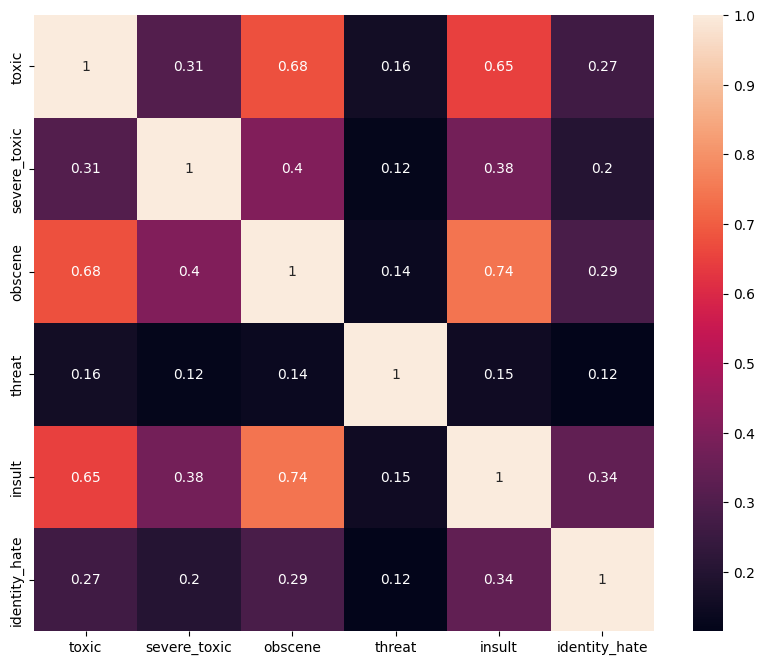

In [9]:
temp_df=train.iloc[:,0:]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [10]:
train.dtypes

comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

### Preprocessing

    remove accented
    removing punctuation
    removing irrelevant characters
    removing extra whitespaces
    lemmatization

In [16]:
def rem_accented(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def rem_puntucation(text):
    pat = r'[^a-zA-Z0-9;\"\'\s]'
    return re.sub(pat, '',text)
def get_long(text):
    text = re.sub(r"can't", "can not",text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'s", " is ", text)
    return text
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!"?/:;\"\'\s]' 
    return re.sub(pat, '', text)
    
# stopwords
stops = stopwords.words("english") 
delete = ['no',
'nor',
'not',
'don',
"don't",
'ain',
'aren',
"aren't",
'couldn',
"couldn't",
'didn',
"didn't",
'doesn',
"doesn't",
'hadn',
"hadn't",
'hasn',
"hasn't",
'haven',
"haven't",
'isn',
"isn't",
'ma',
'mightn',
"mightn't",
'mustn',
"mustn't",
'needn',
"needn't",
'shan',
"shan't",
'shouldn',
"shouldn't",
'wasn',
"wasn't",
'weren',
"weren't",
'won',
"won't",
'wouldn',
"wouldn't"]
new = [stop for stop in stops if stop not in delete]

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# def get_lemmatization(text):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def get_lemmatization(text):
    # Tokenize: Split the sentence into words
    word_list = nltk.word_tokenize(text)
    # Lemmatize list of words and join
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [17]:
def preprocess(df):
    df['comment_text'] = df['comment_text'].astype(str)
    df['clean_comment'] = df['comment_text'].str.lower()
    df['clean_comment'] = df['clean_comment'].apply(rem_puntucation)
    df['clean_comment'] = df['clean_comment'].apply(get_long)
    df['clean_comment'] = df['clean_comment'].apply(remove_special_characters)
    df['clean_comment'] = df['clean_comment'].apply(lambda x: ' '.join([item for item in x.split() if item not in new]))
    df['clean_comment'] = df['clean_comment'].apply(rem_accented)
    df['clean_comment'] = df['clean_comment'].apply(get_lemmatization)
    return df

preproceesing training data

In [22]:
train = preprocess(train)

In [23]:
train.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww match background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really not trying edit war guy constan...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,`` not make real suggestion improvement wonder...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


In [25]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
ytrain = train[list_classes].values
Xtrain = train["clean_comment"]

tokenizing the training set

In [26]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(Xtrain))
X_tokenized_train = tokenizer.texts_to_sequences(Xtrain)

special characters that still remianed after preprocessing were not assigned values

In [27]:
x = '`` "" '
tokenizer.texts_to_sequences(x)

[[], [], [], [], [], []]

Input of the NN needs to be fixed length , so choosing a suitable max length of tokens. If the input is short then it is padded.

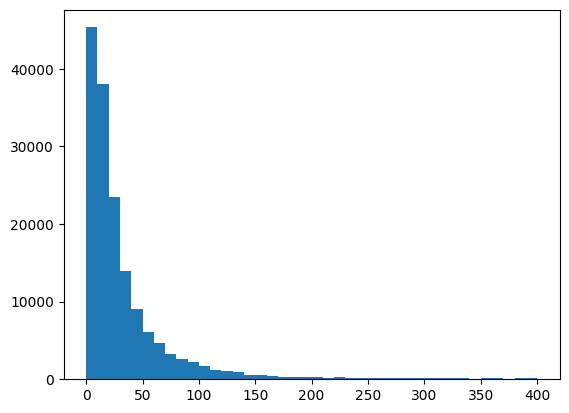

In [28]:
totalNumWords = [len(one_comment) for one_comment in X_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

200 seems to be a safe maxlength of tokens

In [29]:
maxlen = 200
X_t = pad_sequences(X_tokenized_train, maxlen=maxlen)

log directory for tensorboard

In [30]:
logDir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
print("logDir: ", logDir)

logDir:  logs/fit/20221002-233002


In [31]:
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
print(model.summary())

2022-10-02 23:30:03.657310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-02 23:30:03.657438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-02 23:30:03.657473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-02 23:30:03.657780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-02 23:30:03.657819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not op

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [ ]:
batch_size = 32
epochs = 25
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=1)
history = model.fit(X_t,ytrain, batch_size=batch_size, epochs=epochs,callbacks=[tensorboard_callback], validation_split=0.1,shuffle=True)

Epoch 1/25


2022-10-02 23:30:12.132344: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 114890400 exceeds 10% of free system memory.
2022-10-02 23:30:15.319444: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


4487/4488 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9508

2022-10-02 23:33:22.895193: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-10-02 23:33:23.606652: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-10-02 23:33:23.659317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-10-02 23:33:23.664325: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.


4488/4488 [==============================] - 193s 42ms/step - loss: 0.0744 - accuracy: 0.9509 - val_loss: 0.0517 - val_accuracy: 0.9940
Epoch 2/25
4488/4488 [==============================] - 177s 40ms/step - loss: 0.0459 - accuracy: 0.9918 - val_loss: 0.0487 - val_accuracy: 0.9940
Epoch 3/25
4488/4488 [==============================] - 172s 38ms/step - loss: 0.0403 - accuracy: 0.9831 - val_loss: 0.0490 - val_accuracy: 0.9916
Epoch 4/25
4488/4488 [==============================] - 174s 39ms/step - loss: 0.0351 - accuracy: 0.9581 - val_loss: 0.0513 - val_accuracy: 0.9937
Epoch 5/25
4488/4488 [==============================] - 184s 41ms/step - loss: 0.0307 - accuracy: 0.9279 - val_loss: 0.0545 - val_accuracy: 0.9915
Epoch 6/25
4488/4488 [==============================] - 182s 40ms/step - loss: 0.0269 - accuracy: 0.8629 - val_loss: 0.0605 - val_accuracy: 0.9680
Epoch 7/25
4488/4488 [==============================] - 175s 39ms/step - loss: 0.0236 - accuracy: 0.8159 - val_loss: 0.0649 - val

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
#!mkdir -p saved_model
#model.save('saved_model/model1')

In [17]:
model = tf.keras.models.load_model('saved_model/model1')

/home/mew/anaconda3/envs/tf/lib/python3.9/site-packages/keras/saving/saved_model/load.py:115: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  metadata.ParseFromString(file_content)


### predicting for test set

In [ ]:
test = preprocess(test)
X_tokenized_test = tokenizer.texts_to_sequences(test['clean_comment'])
X_te = pad_sequences(X_tokenized_test, maxlen=maxlen)
y_pred = model.predict(X_te,batch_size=1024,verbose=1)

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission.csv', index=False)

### predict for given input

In [24]:
input1= {'comment_text': 'you are a looser'} #input text here
inputdf = pd.DataFrame(input1,index=[0])
inputdf = preprocess(inputdf)
X_tokenized_input = tokenizer.texts_to_sequences(inputdf['clean_comment'])
X_ip = pad_sequences(X_tokenized_input, maxlen=maxlen)
y_pred = model.predict(X_ip,verbose=1)

1/1 [==============================] - 0s 403ms/step


In [25]:
for i in range(0,6):
    print(list_classes[i], ':' , round(y_pred[0][i]*100,2),'%')

toxic : 86.49 %
severe_toxic : 5.34 %
obscene : 47.72 %
threat : 4.57 %
insult : 49.0 %
identity_hate : 8.89 %
